In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pickle

from utils import LabelToImageNet, sample_from_autoencoder, get_sequential_model, crossentropy_for_gray, sample_images_from_vae, SimpleEncoder, SimpleDecoder, Encoder, Decoder, VAE, vae_loss, display_latents

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def to_binary(x):
    zero_mask = x < 0.5
    x[zero_mask] = 0.
    x[~zero_mask] = 1.
    return x

train_dataset_gray = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

test_dataset_gray = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor()
]))

train_dataset_binary = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))

test_dataset_binary = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))


N_val = 1000
N_train = len(train_dataset_binary) - N_val
N_test = len(test_dataset_binary)

cuda
/home/syslink/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:179.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/home/syslink/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:135: UserWarning: Legacy tensor constructor is deprecated. Use: torch.tensor(...) for creating tensors from tensor-like objects; or torch.empty(...) for creating an uninitialized tensor with specific sizes. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_new.cpp:477.)
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


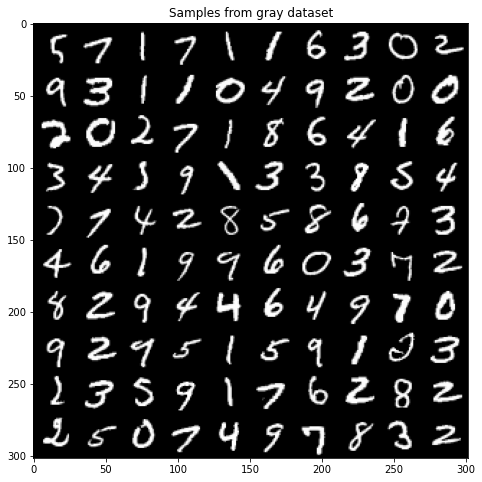

In [3]:
def make_image_grid(images, nrow=8):
    images = images.float()  # from {0,1,2,3} ints to [0,1] floats
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

plt.figure(figsize=(8, 8))
plt.title('Samples from gray dataset')
it = iter(train_dataset_gray)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack([next(it)[0] for _ in range(100)], dim=0), nrow=10))
del it


torch.Size([1, 28, 28])


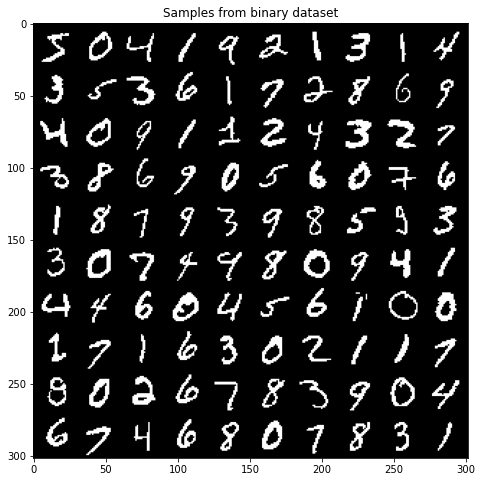

In [4]:
plt.figure(figsize=(8, 8))
plt.title('Samples from binary dataset')
it = iter(train_dataset_binary)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack(imgs, dim=0), nrow=10))
print(imgs[0].size())
del it


In [5]:
lr = 1e-4
reg = 1e-4
batch_size = 32
flatten_img_size = 28 * 28
# %%

# alternatively model = torch.nn.Sequential( ?? )
def flatten_processor(output):
    return torch.flatten(output)

def make_float_processor(imgs):
    return imgs.float()


def calculate_nll(output, imgs, mse, custom_loss, loss):
    if mse:
        nll = loss(torch.flatten(output), imgs.float())
    else:
        if not custom_loss:
            outputs = torch.stack(
                [torch.flatten(1 - output), torch.flatten(output)], dim=1
            )
            nll = loss(outputs, imgs.long())

        else:
            outputs = torch.flatten(output)
            nll = loss(outputs, imgs)
    return nll


def train(model, train_loader, val_loader, loss, custom_loss=False, mse=False, save_path='./data/test', num_epochs=50, verbose=True, lr=lr):
    writer = SummaryWriter()
    train_nll_history = []
    val_nll_history = []

    optimizer = optim.Adam(model.parameters(), lr, weight_decay=reg)

    for epoch in range(num_epochs):
        if verbose:
            print(f'Epoch {epoch + 1} / {num_epochs} ', end='')
        
        model.train()
        train_nlls = []
        for i, minibatch in enumerate(train_loader):
            optimizer.zero_grad()

            labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
            imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

            output = model(labels)
            
            nll = calculate_nll(output, imgs, mse, custom_loss, loss)
            train_nlls.append(nll.item())

            nll.backward()
            optimizer.step()
            
            
            if i % 50 == 0:
                print('.', end='')
        
        train_loss = np.mean(train_nlls)
        train_nll_history.append(train_loss)


        writer.add_scalar("Loss/train", train_loss, epoch)


        # compute nll on validation set
        val_nlls = []
        model.eval()

        with torch.no_grad():
            for val_minibatch in val_loader:
                val_labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
                val_imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

                output = model(val_labels)
                val_nll = calculate_nll(output, val_imgs, mse, custom_loss, loss)
                val_nlls.append(val_nll.item())

        val_loss = np.mean(val_nlls)

        writer.add_scalar("Loss/val", val_loss, epoch)
        val_nll_history.append(val_loss)
        print("loss: ", val_loss)
        
        samples = sample_from_autoencoder(model, 10, device).detach()
        img = make_image_grid(samples, nrow=5)
        plt.imsave(os.path.join(save_path, f'epoch_{epoch}.jpg'), img)
        #plt.imshow(img)
        #plt.show()

    writer.flush()
    return train_nll_history, val_nll_history


### You can call and check trainings and validation losses also on the tensorboard. For that run:
tensorboard --logdir ./runs

### Gray Images with Cross-Entropy loss based on nn.Module
Images are saved in ./data/gray_cross_module_nn

In [20]:
model = LabelToImageNet().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_nll_history, val_nll_history = train(model, train_loader, val_loader, crossentropy_for_gray, custom_loss=True, mse=False, save_path='./data/gray_cross_module_nn', num_epochs=20)

Epoch 1 / 20 .....................................loss:  0.262386679649353










Epoch 2 / 20 .....................................loss:  0.25768548250198364










Epoch 3 / 20 .....................................loss:  0.2512897551059723










Epoch 4 / 20 .....................................loss:  0.2285185307264328










Epoch 5 / 20 .....................................loss:  0.23321428894996643










Epoch 6 / 20 .....................................loss:  0.23058822751045227










Epoch 7 / 20 .....................................loss:  0.23944294452667236










Epoch 8 / 20 .....................................loss:  0.24302932620048523










Epoch 9 / 20 .....................................loss:  0.24359533190727234










Epoch 10 / 20 .....................................loss:  0.23017986118793488










Epoch 11 / 20 .....................................loss:  0.2176363170146942










Epoch 12 / 20 ................................

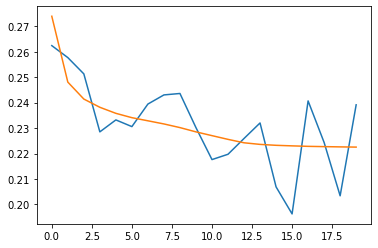

In [21]:
plt.plot(val_nll_history)
plt.plot(train_nll_history)


### Binary Images with Cross-Entropy loss based on nn.Module
Images are saved in ./data/binary_cross_module_nn

In [6]:
model = LabelToImageNet().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=256,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=256,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_nll_history, val_nll_history = train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_module_nn', num_epochs=100)


Epoch 1 / 100 .....loss:  0.44043537974357605










Epoch 2 / 100 .....loss:  0.4364701807498932










Epoch 3 / 100 .....loss:  0.4308411777019501










Epoch 4 / 100 .....loss:  0.4243646264076233










Epoch 5 / 100 .....loss:  0.4305778741836548










Epoch 6 / 100 .....loss:  0.4290492832660675










Epoch 7 / 100 .....loss:  0.42951464653015137










Epoch 8 / 100 .....loss:  0.4258478879928589










Epoch 9 / 100 .....loss:  0.43193966150283813










Epoch 10 / 100 .....loss:  0.4274696409702301










Epoch 11 / 100 .....loss:  0.42651450634002686










Epoch 12 / 100 .....loss:  0.4261150062084198










Epoch 13 / 100 .....loss:  0.4272101819515228










Epoch 14 / 100 .....loss:  0.42686909437179565










Epoch 15 / 100 .....loss:  0.4203297793865204










Epoch 16 / 100 .....loss:  0.4244755208492279










Epoch 17 / 100 .....loss:  0.42378631234169006










Epoch 18 / 100 .....loss:  0.4267694056034088







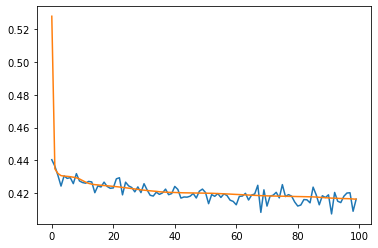

In [7]:
plt.plot(val_nll_history)
plt.plot(train_nll_history)

### Binary Images with Cross-Entropy loss based on Sequential
Images are saved in ./data/binary_cross_sequential


Epoch 1 / 100 .....................................loss:  0.4367429316043854










Epoch 2 / 100 .....................................loss:  0.42614471912384033










Epoch 3 / 100 .....................................loss:  0.43954095244407654










Epoch 4 / 100 .....................................loss:  0.430754154920578










Epoch 5 / 100 .....................................loss:  0.41109612584114075










Epoch 6 / 100 .....................................loss:  0.42801567912101746










Epoch 7 / 100 .....................................loss:  0.43298614025115967










Epoch 8 / 100 .....................................loss:  0.4298807680606842










Epoch 9 / 100 .....................................loss:  0.4155410826206207










Epoch 10 / 100 .....................................loss:  0.4228985011577606










Epoch 11 / 100 .....................................loss:  0.42091208696365356










Epoch 12 / 100 .....................

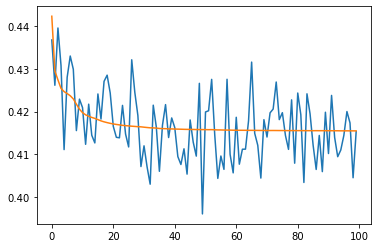

In [9]:
model = get_sequential_model().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_nll_history, val_nll_history = train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_sequential', num_epochs=100)
plt.plot(val_nll_history)
plt.plot(train_nll_history)


### Gray Images with MSE loss based on Sequential
Images are saved in ./data/gray_mse_sequential

Epoch 1 / 30 .....................................loss:  0.06716908514499664










Epoch 2 / 30 .....................................loss:  0.061111994087696075










Epoch 3 / 30 .....................................loss:  0.05237940698862076










Epoch 4 / 30 .....................................loss:  0.05713733285665512










Epoch 5 / 30 .....................................loss:  0.061022788286209106










Epoch 6 / 30 .....................................loss:  0.059366002678871155










Epoch 7 / 30 .....................................loss:  0.05736421048641205










Epoch 8 / 30 .....................................loss:  0.06195787712931633










Epoch 9 / 30 .....................................loss:  0.060336001217365265










Epoch 10 / 30 .....................................loss:  0.046201687306165695










Epoch 11 / 30 .....................................loss:  0.061690010130405426










Epoch 12 / 30 .....................

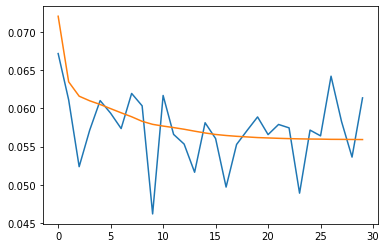

In [13]:
model = get_sequential_model().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_nll_history, val_nll_history = train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/gray_mse_sequential', num_epochs=30)
plt.plot(val_nll_history)
plt.plot(train_nll_history)

### Binary Images with MSE loss based on Sequential
Images are saved in ./data/binary_mse_sequential

Epoch 1 / 100 .....................................loss:  0.08315835893154144










Epoch 2 / 100 .....................................loss:  0.08076101541519165










Epoch 3 / 100 .....................................loss:  0.08660303056240082










Epoch 4 / 100 .....................................loss:  0.07658927887678146










Epoch 5 / 100 .....................................loss:  0.08260630816221237










Epoch 6 / 100 .....................................loss:  0.08709689229726791










Epoch 7 / 100 .....................................loss:  0.07950463891029358










Epoch 8 / 100 .....................................loss:  0.07710886001586914










Epoch 9 / 100 .....................................loss:  0.07209205627441406










Epoch 10 / 100 .....................................loss:  0.08078695833683014










Epoch 11 / 100 .....................................loss:  0.07400430738925934










Epoch 12 / 100 ...............

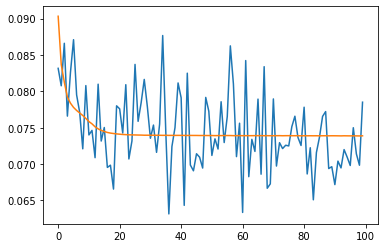

In [14]:
model = get_sequential_model().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))

train_nll_history, val_nll_history = train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/binary_mse_sequential', num_epochs=100)
plt.plot(val_nll_history)
plt.plot(train_nll_history)

What is the interpretation of grey scale in a cross entropyloss?

We would still have two classes for types black and white, and we will take all gray pixels as value in between this classes. However here if target and prediction are both not zero or both one, the loss will not be equal to 0 as it would normally be in standard BCE. In other words, even when predicted and true value are the same the loss will not be zero.

What is the interpretation of grey scale in the mean squared error?
However in case of gray scale error we don't have this problem anymore, when both labels are the same, the loss is going to be 0 again. So this loss is more strict in pushing the output to habe a blurry border.

### This model was trained with simple BCE and DKL loss

In [ ]:
def train_VAE(vae, dataloader, epochs=3, verbose=False):
    vae = vae.to(device)
    optimizer = optim.Adam(params=vae.parameters(), lr=1e-4)
    vae.train()

    losses = []
    reconstruction_losses = []
    KL_losses = []
    all_losses = [] 

    final_KL = 0
    final_reconstr = 0

    for epoch in range(epochs):
        losses.append(0)
        n_batches = 0

        for sample in dataloader:
            sample = torch.reshape(sample[0], (-1, 28 * 28)).to(device).float()
            optimizer.zero_grad()
            mu_z, log_std_z, reconstruction = vae(sample)

            (loss, reconstruction_loss, KL_loss) = vae_loss(sample, mu_z, log_std_z, reconstruction)
            loss.backward()

            optimizer.step()
            losses[-1] += loss.item()
            final_KL += KL_loss.item()
            final_reconstr += reconstruction_loss.item()

            reconstruction_losses.append(reconstruction_loss.item())
            KL_losses.append(KL_loss.item())
            all_losses.append(loss.item())

            n_batches += 1

        losses[-1] /= n_batches
        final_KL /= n_batches
        final_reconstr /= n_batches

        if not verbose:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch + 1, epochs, losses[-1]))  
    
    return all_losses, reconstruction_losses, KL_losses, losses[-1], final_reconstr, final_KL


def print_training_results(all_losses, reconstruction_losses, KL_losses, y_lim=(-1, 10), x_lim=(0, 30000)):
    figure(figsize=(8, 6), dpi=80)
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlim(x_lim[0], x_lim[1])


    line_loss = plt.plot(range(len(all_losses)), all_losses, color='palegreen', label='ELBO')
    line_rec = plt.plot(range(len(reconstruction_losses)), reconstruction_losses, color='gold', label='reconstruction_loss')
    line_kl = plt.plot(range(len(KL_losses)), KL_losses, color='mediumorchid', label='KL_loss')
    plt.legend()
    plt.show()


In [30]:
model = VAE(28 * 28, 2, simple=True).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=32,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=32,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_VAE(model, train_loader, epochs=100)


Epoch [1 / 100] average reconstruction error: 6592.067545
Epoch [2 / 100] average reconstruction error: 5707.575781
Epoch [3 / 100] average reconstruction error: 5215.665370
Epoch [4 / 100] average reconstruction error: 5026.700037
Epoch [5 / 100] average reconstruction error: 4877.629485
Epoch [6 / 100] average reconstruction error: 4748.079028
Epoch [7 / 100] average reconstruction error: 4647.929162
Epoch [8 / 100] average reconstruction error: 4567.729581
Epoch [9 / 100] average reconstruction error: 4504.890901
Epoch [10 / 100] average reconstruction error: 4452.630377
Epoch [11 / 100] average reconstruction error: 4408.340350
Epoch [12 / 100] average reconstruction error: 4371.054066
Epoch [13 / 100] average reconstruction error: 4341.051474
Epoch [14 / 100] average reconstruction error: 4312.616127
Epoch [15 / 100] average reconstruction error: 4289.705907
Epoch [16 / 100] average reconstruction error: 4267.923702
Epoch [17 / 100] average reconstruction error: 4248.408731
Epoch 

([17458.109375,
  17421.181640625,
  17384.796875,
  17350.08984375,
  17313.646484375,
  17284.216796875,
  17235.1953125,
  17179.6484375,
  17151.916015625,
  17104.23828125,
  17103.59375,
  17062.318359375,
  17000.546875,
  16955.90234375,
  16917.87890625,
  16873.08984375,
  16816.056640625,
  16804.7734375,
  16723.001953125,
  16538.712890625,
  16514.7109375,
  16468.603515625,
  16364.5,
  16335.03515625,
  16184.892578125,
  16089.1953125,
  15952.251953125,
  15963.1259765625,
  15763.578125,
  15650.6796875,
  15524.095703125,
  15460.767578125,
  15366.287109375,
  15052.5390625,
  15176.1806640625,
  14683.513671875,
  14046.36328125,
  14112.4775390625,
  13965.0322265625,
  13545.5078125,
  13787.787109375,
  13014.125,
  12785.486328125,
  12859.3310546875,
  12337.56640625,
  11983.453125,
  11537.8544921875,
  11488.8115234375,
  11174.5966796875,
  10545.1044921875,
  11152.8232421875,
  9583.673828125,
  10246.3076171875,
  9606.3017578125,
  10581.4970703125,
 

In [4]:
model = VAE(28 * 28, 2).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_VAE(model, train_loader, epochs=100)

Epoch [1 / 100] average reconstruction error: 83245.856940
Epoch [2 / 100] average reconstruction error: 51960.808949
Epoch [3 / 100] average reconstruction error: 50534.966560
Epoch [4 / 100] average reconstruction error: 49582.389205
Epoch [5 / 100] average reconstruction error: 48816.957784
Epoch [6 / 100] average reconstruction error: 48225.533753
Epoch [7 / 100] average reconstruction error: 47757.797298
Epoch [8 / 100] average reconstruction error: 47396.423532
Epoch [9 / 100] average reconstruction error: 47099.628813
Epoch [10 / 100] average reconstruction error: 46828.318461
Epoch [11 / 100] average reconstruction error: 46538.665026
Epoch [12 / 100] average reconstruction error: 46116.005741
Epoch [13 / 100] average reconstruction error: 45116.995206
Epoch [14 / 100] average reconstruction error: 44093.985998
Epoch [15 / 100] average reconstruction error: 43505.143550
Epoch [16 / 100] average reconstruction error: 43070.858732
Epoch [17 / 100] average reconstruction error: 42

([139212.6875,
  139051.6875,
  138879.21875,
  138719.59375,
  138554.375,
  138397.421875,
  138235.1875,
  138049.0625,
  137872.65625,
  137681.65625,
  137520.4375,
  137325.171875,
  137134.625,
  136924.375,
  136714.6875,
  136466.6875,
  136249.296875,
  135941.734375,
  135736.90625,
  135521.46875,
  135284.90625,
  134924.734375,
  134651.5,
  134355.265625,
  134093.375,
  133747.75,
  133337.21875,
  132992.921875,
  132576.703125,
  132233.3125,
  131863.46875,
  131405.171875,
  131017.0546875,
  130569.625,
  130147.578125,
  129766.109375,
  129203.0703125,
  128706.7734375,
  128190.859375,
  127665.09375,
  127198.1484375,
  126739.390625,
  125881.5,
  125308.5078125,
  124736.59375,
  124155.03125,
  123365.1875,
  123024.5859375,
  122272.4296875,
  121700.6640625,
  120961.7734375,
  120234.984375,
  119578.109375,
  118904.3125,
  118119.4140625,
  117215.3203125,
  116698.546875,
  115818.4140625,
  115083.828125,
  114039.1171875,
  113283.59375,
  113118.890

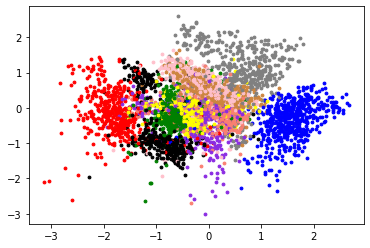

In [80]:
test_loader = torch.utils.data.DataLoader(test_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(5000))))
display_latents(model, test_loader)

### Let's take 100 random samples from the model

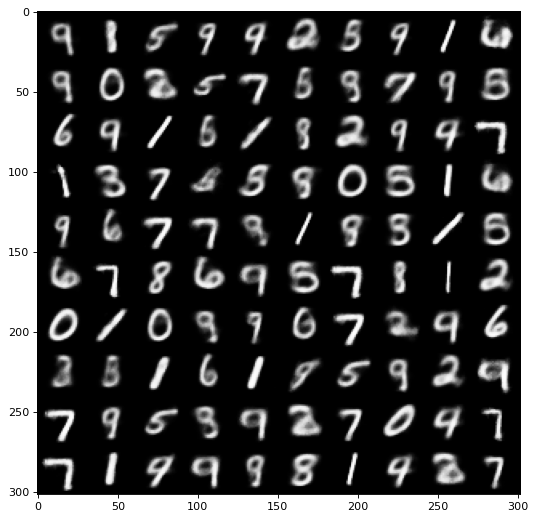

In [81]:
noise = False
n = 100

figure(figsize=(8, 8), dpi=80)

with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    reconstructed = model.decoder(z)
    if noise:
        z = torch.randn_like(mu) * log_std.exp() + mu
    else:
        z = reconstructed
imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)

nrows = 10
grid = torchvision.utils.make_grid(imgs, nrows)
grid = grid.detach().cpu().numpy()[1, :, :]  # from CHW to HWC
plt.imshow(1 - grid, cmap='Greys')

### This model was trained with Loss suggested in the task

In [17]:
def get_loss(x, vae):            
    x = torch.reshape(x, (-1, 28 * 28)).to(device).float()
    x = torch.cat(10 * [x])
    
    mu_z, log_std_z = vae.encoder(x)
    z = vae.sample_latent(mu_z, log_std_z)

    reconstruction = vae.decoder(z)

    cross_entropy = F.binary_cross_entropy(reconstruction, x, reduction='none')
    logpx_z = -cross_entropy.sum(dim=1)

    std = torch.exp(log_std_z)

    p = torch.distributions.Normal(torch.zeros_like(mu_z), torch.ones_like(std))
    q = torch.distributions.Normal(mu_z, std)

    logqz_x = q.log_prob(z)
    logpz = p.log_prob(z)

    logqz_x = logqz_x.sum(dim=1)
    logpz = logpz.sum(dim=1)

    elbo = -(logpx_z + logpz - logqz_x)

    loss = elbo.mean()

    return loss


def train_custom_loss_VAE(vae, train_dataloader, epochs=3, verbose=False):
    vae = vae.to(device)
    optimizer = optim.Adam(params=vae.parameters(), lr=1e-4)
    vae.train()

    train_losses = []

    for epoch in range(epochs):
        losses.append(0)
        n_batches = 0

        for sample in train_dataloader:
            optimizer.zero_grad()

            loss = get_loss(sample[0], vae)

            loss.backward()

            optimizer.step()
            train_losses[-1] += loss.item()
            n_batches += 1

        train_losses[-1] /= n_batches

        if not verbose:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch + 1, epochs, losses[-1]))  
    
    return train_losses


In [9]:

model = VAE(28 * 28, 2).to(device).float()
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=32,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
test_loader = torch.utils.data.DataLoader(test_dataset_binary, batch_size=32,
                                         sampler=SubsetRandomSampler(list(range(N_test))))
train_losses = train_custom_loss_VAE(model, train_loader, epochs=100)


Epoch [1 / 100] average reconstruction error: 214.803169
Epoch [2 / 100] average reconstruction error: 188.281483
Epoch [3 / 100] average reconstruction error: 185.781572
Epoch [4 / 100] average reconstruction error: 183.074496
Epoch [5 / 100] average reconstruction error: 181.138887
Epoch [6 / 100] average reconstruction error: 179.961046
Epoch [7 / 100] average reconstruction error: 178.888423
Epoch [8 / 100] average reconstruction error: 177.740653
Epoch [9 / 100] average reconstruction error: 176.490395
Epoch [10 / 100] average reconstruction error: 175.178480
Epoch [11 / 100] average reconstruction error: 173.750186
Epoch [12 / 100] average reconstruction error: 172.099068
Epoch [13 / 100] average reconstruction error: 170.281383
Epoch [14 / 100] average reconstruction error: 168.794239
Epoch [15 / 100] average reconstruction error: 167.847318
Epoch [16 / 100] average reconstruction error: 166.931003
Epoch [17 / 100] average reconstruction error: 165.704885
Epoch [18 / 100] averag

### Final losses

In [25]:
n_batches = 0
test_loss = 0
for sample in test_loader:
    test_loss += get_loss(sample[0], model)
    n_batches += 1
test_loss /= n_batches / np.log(2)
print("Last epoch train loss in bits per dim: ", train_losses[3] / np.log(2))
print("Test loss in bits per dim: ", test_loss)

Last epoch train loss in bits per dim:  200.21726340755902
Test loss in bits per dim:  tensor(99.1443, device='cuda:0', grad_fn=<DivBackward0>)


### Latent space evaluation

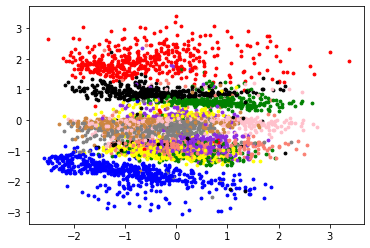

In [13]:
display_latents(model, test_loader, device)

### Samples from the dataset

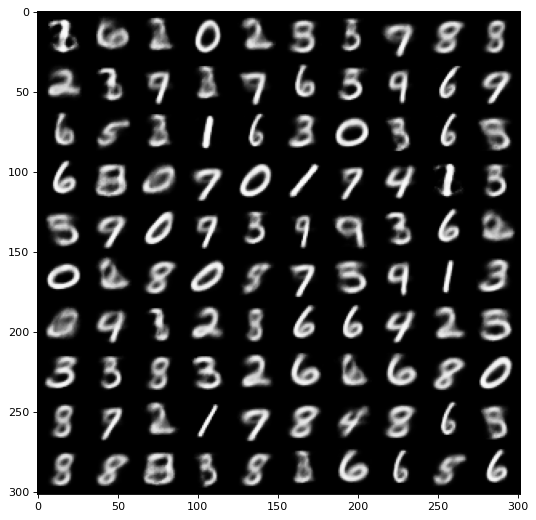

In [15]:
def sample_images_from_vae(model, n, noise=False):
    plt.figure(figsize=(8, 8), dpi=80)

    with torch.no_grad():
        z = torch.randn(n, 2).to(device)
        reconstructed = model.decoder(z)
        if noise:
            z = torch.randn_like(mu) * log_std.exp() + mu
        else:
            z = reconstructed
    imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)

    nrows = 10
    grid = torchvision.utils.make_grid(imgs, nrows)
    grid = grid.detach().cpu().numpy()[1, :, :]  # from CHW to HWC
    plt.imshow(1 - grid, cmap='Greys')


sample_images_from_vae(model, 100, device)